In [13]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import h_transport_materials as htm

ureg = htm.ureg
ureg.setup_matplotlib()
ureg.define('neutron = 1 * particle = n')


In [14]:
# geometry
V_salt = 1 * ureg.L
radius = 7 * ureg.cm
A_top = np.pi * radius **2
height = V_salt / A_top

height_to_radius = height/radius
volume_to_radius = V_salt/radius

L_wall = 1 * ureg.cm
perimeter_sweep = 2 * np.pi * (radius + L_wall)
A_sweep = perimeter_sweep * height

print("Surface areas:")
print(f"Walls: {A_sweep.to(ureg.cm**2):.2f~P}")
print(f"Top: {A_top.to(ureg.cm**2):.2f~P}")
# print(height.to(ureg.cm))

# source
neutron_rate = 3e8 * ureg.neutron * ureg.s**-1
def compute_TBR(radius_salt):
    ratio = 0.01 * ureg.particle * ureg.neutron**-1 / (7 * ureg.cm)
    return ratio * radius_salt

TBR = compute_TBR(radius)
S = TBR * neutron_rate

# H properties
K_salt = 1e20 * ureg.particle * ureg.m**-3 * ureg.Pa**-1
K_wall = 1e20 * ureg.particle * ureg.m**-3 * ureg.Pa**-0.5
D_wall = 1e-8 * ureg.m**2 * ureg.s**-1
D_salt = 6e-9* ureg.m**2 * ureg.s**-1

print("Characteristic times:")
print(f"Through top surface: {(height**2/(6* D_salt)).to(ureg.h):.2f~P}")
print(f"Through walls: {(L_wall**2/(6* D_wall)).to(ureg.h):.2f~P}")

# def J_sweep(c_0, t, x):
#     """Eq 8 from https://link.springer.com/article/10.1007/BF01653631
#     """
#     steady_flux = D_wall * c_0/L_wall
#     D_eff = D_wall
#     tau = L_wall**2/D_eff
#     n = np.arange(1, 1000)
#     n = n[:, np.newaxis]
#     infinite_sum = np.cos(np.pi * n * x / L_wall) * np.exp(-n**2 * np.pi**2 * t/tau)
#     infinite_sum = np.sum(infinite_sum, axis=0)
#     transient_flux = steady_flux * (1 + 2 * infinite_sum)
#     return transient_flux


# def Q_sweep(c_salt, t):
#     # return A_sweep / L_wall * D_wall * K_wall / (K_salt**0.5) * c_salt**0.5
#     c_0 = K_wall / (K_salt**0.5) * c_salt**0.5
#     return A_sweep * J_sweep(c_0, t, x=0*ureg.m)

def Q_sweep(c_salt, t):
    K_sweep = 1.9e-8 * ureg.m * ureg.s**-1  # from Kumagai
    return A_sweep * K_sweep * c_salt


def Q_top(c_salt):
    K_top = 4.9e-7 * ureg.m * ureg.s**-1  # from Kumagai
    return A_top * K_top * c_salt

Surface areas:
Walls: 326.53 cm²
Top: 153.94 cm²
Characteristic times:
Through top surface: 32.56 h
Through walls: 0.46 h


In [16]:
def equation(c, t):
    c *= ureg.particle * ureg.m**-3
    if t < exposure_time:
        S_current = S
    else:
        S_current = 0 * S
    lhs = V_salt * (c - c_old) / dt
    rhs = S_current - Q_sweep(c, t) - Q_top(c)
    return lhs - rhs

c_old = 0 * ureg.particle * ureg.m**-3
dt = 1 * ureg.h
exposure_time = 300 * ureg.h

concentrations = []
times = []

t = 0 * ureg.s
while t < exposure_time * 2:
    t += dt
    c_new = fsolve(equation, x0=c_old, args=(t,))* ureg.particle * ureg.m**-3
    c_old = c_new

    times.append(t)
    concentrations.append(c_new)
concentrations = ureg.Quantity.from_list(concentrations)
times = ureg.Quantity.from_list(times)


C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:222: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x0 = asarray(x0).flatten()
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:237: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


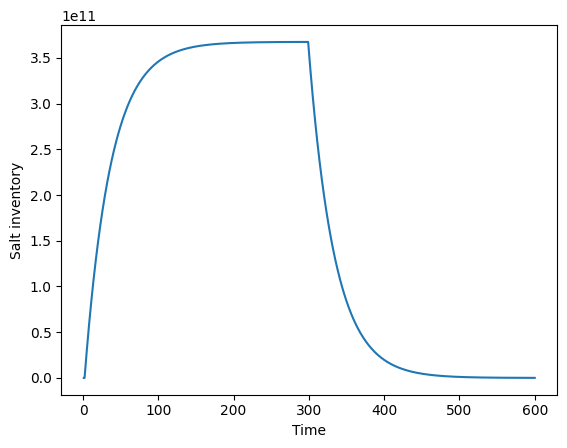

In [17]:
inventory = concentrations * V_salt
plt.plot(times.to(ureg.h), inventory.to(ureg.particle))
plt.xlabel("Time")
plt.ylabel("Salt inventory")
plt.show()


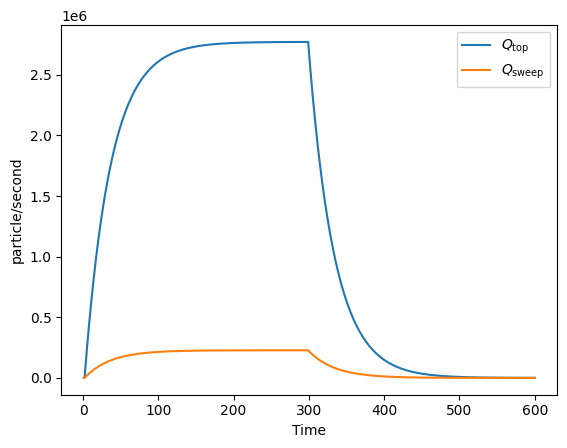

In [18]:
release_top = Q_top(concentrations).to(ureg.particle * ureg.s**-1)
release_walls = Q_sweep(concentrations, times).to(ureg.particle * ureg.s**-1)
plt.plot(times.to(ureg.h), release_top, label="$Q_\mathrm{top}$")
plt.plot(times.to(ureg.h), release_walls, label="$Q_\mathrm{sweep}$")
plt.xlabel("Time")
# plt.ylabel("Release")
# plt.yscale("log")
plt.legend()
plt.show()


In [21]:
radius_values = [1, 2, 3, 4, 5, 6, 7] * ureg.cm
volume_values = []
concentrations_all = []
times_all = []

for radius in radius_values:
    A_top = np.pi*radius**2
    height = height_to_radius * radius
    perimeter_sweep = 2 * np.pi * radius
    A_sweep = perimeter_sweep * height
    V_salt = A_top * height
    volume_values.append(V_salt)
    # print(A_sweep.to(ureg.cm**2), A_top.to(ureg.cm**2))
    TBR = compute_TBR(radius)
    S = TBR * neutron_rate
    print(S)
    c_old = 0 * ureg.particle * ureg.m**-3
    concentrations = []
    times = []

    t = 0 * ureg.h
    while t < exposure_time * 2:
        t += dt
        c_new = fsolve(equation, x0=c_old, args=(t,))* ureg.particle * ureg.m**-3
        c_old = c_new

        times.append(t)
        concentrations.append(c_new)
    concentrations = ureg.Quantity.from_list(concentrations)
    concentrations_all.append(concentrations)
    times = ureg.Quantity.from_list(times)
    times_all.append(times)


volume_values = ureg.Quantity.from_list(volume_values)


428571.4285714286 particle / second
857142.8571428572 particle / second
1285714.2857142857 particle / second
1714285.7142857143 particle / second
2142857.1428571427 particle / second
2571428.5714285714 particle / second
3000000.0 particle / second


C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:222: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x0 = asarray(x0).flatten()
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:237: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


C:\Users\remidm\AppData\Local\Temp\ipykernel_27968\2928139980.py:49: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label=f"Salt volume ({V_salt.units})")
C:\Users\remidm\AppData\Local\Temp\ipykernel_27968\2928139980.py:60: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label=f"Salt volume ({V_salt.units})")


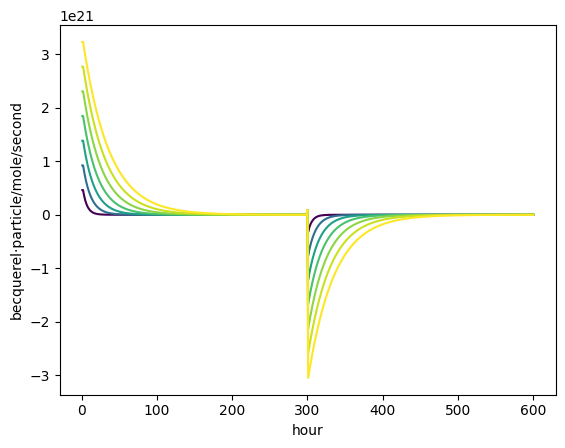

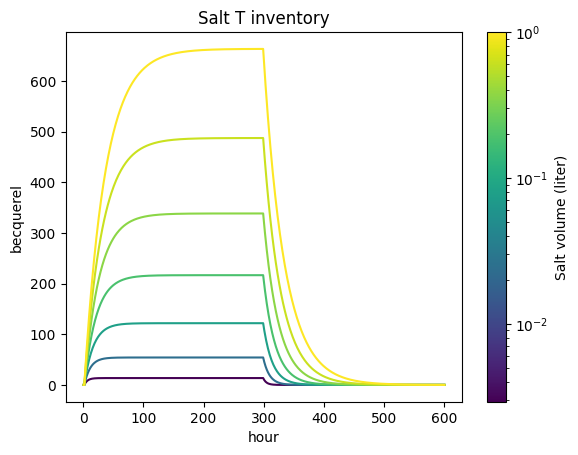

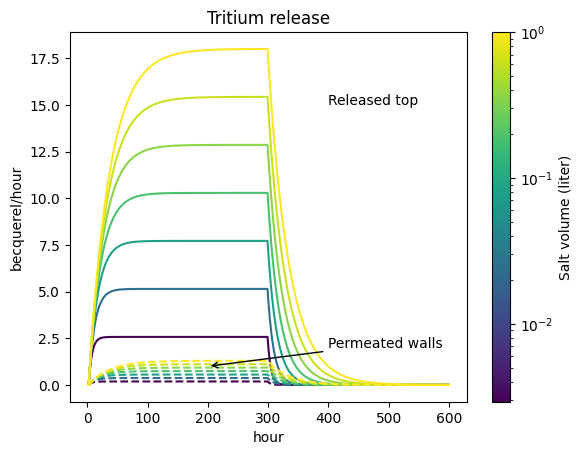

In [50]:
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm

norm_V_salt = LogNorm()
norm_V_salt.autoscale(volume_values.magnitude)
SPECIFIC_ACT = 3.57e14 * ureg.Bq * ureg.g**-1
MOLAR_MASS = 6.032 / 2 * ureg.g * ureg.mol**-1
for i, radius in enumerate(radius_values):
    A_top = np.pi * radius**2
    height = height_to_radius * radius
    perimeter_sweep = 2 * np.pi * radius
    A_sweep = perimeter_sweep * height
    V_salt = A_top * height
    times = times_all[i]
    concentrations = concentrations_all[i]
    inventory = V_salt * concentrations * SPECIFIC_ACT * MOLAR_MASS
    plt.figure(1)
    plt.plot(
        times, inventory.to(ureg.Bq), color=cm.viridis(norm_V_salt(V_salt.magnitude))
    )
    plt.figure(2)
    top_release = (Q_top(concentrations) * SPECIFIC_ACT * MOLAR_MASS).to(
        ureg.Bq * ureg.h**-1
    )
    wall_release = (Q_sweep(concentrations, times) * SPECIFIC_ACT * MOLAR_MASS).to(
        ureg.Bq * ureg.h**-1
    )
    plt.plot(times, top_release, color=cm.viridis(norm_V_salt(V_salt.magnitude)))
    plt.plot(
        times,
        wall_release,
        linestyle="dashed",
        color=cm.viridis(norm_V_salt(V_salt.magnitude)),
    )
    plt.figure(3)
    TBR = compute_TBR(radius_values[i])
    S = TBR * neutron_rate * SPECIFIC_ACT * MOLAR_MASS
    S = S * np.ones_like(times)
    S[np.where(times > exposure_time)] *= 0
    plt.plot(
        times,
        S - top_release - wall_release,
        color=cm.viridis(norm_V_salt(V_salt.magnitude)),
    )
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm_V_salt)

plt.figure(1)
plt.title("Salt T inventory")
plt.colorbar(sm, label=f"Salt volume ({V_salt.units})")
plt.figure(2)
plt.title("Tritium release")
plt.annotate("Released top", (400 * ureg.h, 15 * ureg.Bq * ureg.h**-1))
plt.annotate(
    "Permeated walls",
    (200 * ureg.h, 1 * ureg.Bq * ureg.h**-1),
    (400 * ureg.h, 2 * ureg.Bq * ureg.h**-1),
    
    arrowprops=dict(facecolor="black", arrowstyle="->")
)
plt.colorbar(sm, label=f"Salt volume ({V_salt.units})")
plt.show()
